In [34]:
# Refer https://docs.python.org/3/library/glob.html for GLOB

import tensorflow as tf
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob


# re-size all the images to this
IMAGE_SIZE = [100, 100] 

# training config:
epochs = 5
batch_size = 32



# https://www.kaggle.com/moltean/fruits
train_path = 'fruits-small/data/Training/'
valid_path = 'fruits-small/data/Validation'


# useful for getting number of files
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')

# useful for getting number of classes
folders = glob(train_path + '/*')



# VGG16

In [35]:
# create an instance of ImageDataGenerator
gen = tf.keras.preprocessing.image.ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=tf.keras.applications.vgg16.preprocess_input
)

train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)
valid_generator = gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)

Found 3425 images belonging to 7 classes.
Found 1150 images belonging to 7 classes.


In [36]:
#VGG16 Example

#include_top = True ----> You are going to use the entire pre-trained model which is trained in Imgnet.
#include_top = False

vgg = tf.keras.applications.vgg16.VGG16(input_shape=[100,100,3] ,
                                       weights="imagenet",
                                       include_top=False)

In [37]:
#Dont train existing weights  -- Locking the pretrained weights
for layer in vgg.layers:
    layer.trainable = False

In [38]:
#Adding our layers -- Fully Connected
flatten = tf.keras.layers.Flatten()
#...
finalLayer = tf.keras.layers.Dense(7, activation="softmax")

model = tf.keras.models.Sequential([
    vgg,  #vgg without fully connected network
    flatten, #Adding Flattening
    finalLayer #Adding Output Layer
])

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 7)                 32263     
Total params: 14,746,951
Trainable params: 32,263
Non-trainable params: 14,714,688
_________________________________________________________________


In [39]:
#Compile
model.compile(loss='categorical_crossentropy',
             optimizer='rmsprop',
             metrics=['accuracy'])

In [40]:
#Fit
history = model.fit(train_generator,
                    validation_data=valid_generator,
                   epochs=5,
                   steps_per_epoch= len(train_generator.filenames) // batch_size,
                   validation_steps= len(valid_generator.filenames) // batch_size,
                   use_multiprocessing=False)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 107 steps, validate for 35 steps
Epoch 1/5
107/107 [==============================] - 46s 429ms/step - loss: 0.5406 - accuracy: 0.9649 - val_loss: 0.1603 - val_accuracy: 0.9759
Epoch 2/5
107/107 [==============================] - 48s 444ms/step - loss: 0.0284 - accuracy: 0.9971 - val_loss: 0.0028 - val_accuracy: 0.9991
Epoch 3/5
107/107 [==============================] - 44s 412ms/step - loss: 0.0073 - accuracy: 0.9982 - val_loss: 0.0049 - val_accuracy: 0.9991
Epoch 4/5
107/107 [==============================] - 45s 416ms/step - loss: 0.0019 - accuracy: 0.9994 - val_loss: 0.0053 - val_accuracy: 0.9982
Epoch 5/5
107/107 [==============================] - 43s 404ms/step - loss: 3.5582e-05 - accuracy: 1.0000 - val_loss: 9.7211e-07 - val_accuracy: 1.0000


# Confusion Matrix Solution

In [9]:
# get label mapping for confusion matrix plot later
test_gen = gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k


Found 1150 images belonging to 7 classes.
{'Banana': 0, 'Lemon': 1, 'Mango': 2, 'Orange': 3, 'Pineapple': 4, 'Pomegranate': 5, 'Strawberry': 6}


In [10]:
labels

['Banana',
 'Lemon',
 'Mango',
 'Orange',
 'Pineapple',
 'Pomegranate',
 'Strawberry']

In [11]:


from sklearn.metrics import confusion_matrix
import numpy as np

def get_confusion_matrix(data_path, N):
    
  print("Generating confusion matrix", N)
  predictions = []
  targets = []
  i = 0
  for x, y in gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2):
    i += 1
    if i % 50 == 0:
      print(i)
    p = model.predict(x)
    p = np.argmax(p, axis=1)
    y = np.argmax(y, axis=1)
    predictions = np.concatenate((predictions, p))
    targets = np.concatenate((targets, y))
    if len(targets) >= N:
      break

  cm = confusion_matrix(targets, predictions)
  return cm


cm = get_confusion_matrix(train_path, len(image_files))
print(cm)
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)


Generating confusion matrix 3425
Found 3425 images belonging to 7 classes.
50
[[490   0   0   0   0   0   0]
 [  0 486   0   6   0   0   0]
 [  0   0 490   0   0   0   0]
 [  0   0   0 479   0   0   0]
 [  0   0   0   0 490   0   0]
 [  0   0   0   0   0 492   0]
 [  0   0   0   1   0   0 491]]
Generating confusion matrix 1150
Found 1150 images belonging to 7 classes.
[[166   0   0   0   0   0   0]
 [  1 155   0   8   0   0   0]
 [  0   0 166   0   0   0   0]
 [  0   0   0 160   0   0   0]
 [  0   0   0   0 166   0   0]
 [  0   0   0   0   0 164   0]
 [  0   0   0   0   0   0 164]]


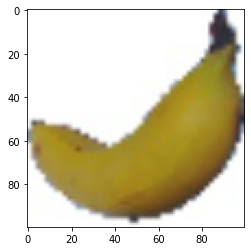

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
#tf.keras.preprocessing.image.load_img(image_files[0])
plt.imshow(tf.keras.preprocessing.image.load_img(image_files[0]))

# Inception v3

In [13]:
gen = tf.keras.preprocessing.image.ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=tf.keras.applications.inception_v3.preprocess_input
)

train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)
valid_generator = gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)

Found 3425 images belonging to 7 classes.
Found 1150 images belonging to 7 classes.


In [31]:

# example of loading the inception v3 model
#from keras.applications.inception_v3 import InceptionV3
# load model
inception = tf.keras.applications.InceptionV3(input_shape=[100,100,3] ,weights="imagenet",include_top=False)

#Dont train existing weights
for layer in inception.layers:
    layer.trainable = False
    
#Adding our layers -- Fully Connected
flatten = tf.keras.layers.Flatten()
#...
finalLayer = tf.keras.layers.Dense(7, activation="softmax")

model = tf.keras.models.Sequential([
    inception,  #vgg without fully connected network
    flatten, #Adding Flattening
    finalLayer #Adding Output Layer
])
     

87916544/87910968 [==============================] - 39s 0us/step


In [32]:
#Compile
model.compile(loss='categorical_crossentropy',
             optimizer='rmsprop',
             metrics=['accuracy'])

In [33]:
#Fit
history = model.fit(train_generator,
                    validation_data=valid_generator,
                   epochs=5,
                   steps_per_epoch= len(train_generator.filenames) // batch_size,
                   validation_steps= len(valid_generator.filenames) // batch_size,
                   use_multiprocessing=False)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 107 steps, validate for 35 steps
Epoch 1/5
107/107 [==============================] - 18s 171ms/step - loss: 1.4132 - accuracy: 0.5503 - val_loss: 1.0737 - val_accuracy: 0.6482
Epoch 2/5
107/107 [==============================] - 12s 115ms/step - loss: 0.9316 - accuracy: 0.7648 - val_loss: 0.5696 - val_accuracy: 0.8089
Epoch 3/5
107/107 [==============================] - 12s 115ms/step - loss: 0.7449 - accuracy: 0.8031 - val_loss: 0.9923 - val_accuracy: 0.7152
Epoch 4/5
107/107 [==============================] - 12s 115ms/step - loss: 0.6404 - accuracy: 0.8190 - val_loss: 0.6339 - val_accuracy: 0.8116
Epoch 5/5
107/107 [==============================] - 12s 113ms/step - loss: 0.5950 - accuracy: 0.8305 - val_loss: 0.6762 - val_accuracy: 0.8134


# Resnet 50

In [15]:
gen = tf.keras.preprocessing.image.ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)
valid_generator = gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)

Found 3425 images belonging to 7 classes.
Found 1150 images belonging to 7 classes.


In [27]:
import tensorflow as tf

# example of loading the inception v3 model
#from keras.applications.resnet50 import ResNet50
# load model
resnet = tf.keras.applications.ResNet50(input_shape=[100,100,3] ,weights="imagenet",include_top=False)

#Dont train existing weights
for layer in resnet.layers:
    layer.trainable = False
    
#Adding our layers -- Fully Connected
flatten = tf.keras.layers.Flatten()
#...
finalLayer = tf.keras.layers.Dense(7, activation="softmax")

model = tf.keras.models.Sequential([
    resnet,
    flatten,
    finalLayer
])

model.summary()

94773248/94765736 [==============================] - 24s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 4, 4, 2048)        23587712  
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 229383    
Total params: 23,817,095
Trainable params: 229,383
Non-trainable params: 23,587,712
_________________________________________________________________


In [28]:
#Compile
model.compile(loss='categorical_crossentropy',
             optimizer='rmsprop',
             metrics=['accuracy'])

In [29]:
#Fit
history = model.fit(train_generator,
                    validation_data=valid_generator,
                   epochs=5,
                   steps_per_epoch= len(train_generator.filenames) // batch_size,
                   validation_steps= len(valid_generator.filenames) // batch_size,
                   use_multiprocessing=False)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 107 steps, validate for 35 steps
Epoch 1/5
107/107 [==============================] - 16s 152ms/step - loss: 0.4127 - accuracy: 0.9646 - val_loss: 7.5816 - val_accuracy: 0.2089
Epoch 2/5
107/107 [==============================] - 12s 115ms/step - loss: 0.0173 - accuracy: 0.9959 - val_loss: 9.4438 - val_accuracy: 0.1991
Epoch 3/5
107/107 [==============================] - 12s 111ms/step - loss: 0.0169 - accuracy: 0.9976 - val_loss: 10.2811 - val_accuracy: 0.1437
Epoch 4/5
107/107 [==============================] - 12s 111ms/step - loss: 0.0312 - accuracy: 0.9973 - val_loss: 9.2447 - val_accuracy: 0.2036
Epoch 5/5
107/107 [==============================] - 12s 117ms/step - loss: 0.0019 - accuracy: 0.9991 - val_loss: 10.8488 - val_accuracy: 0.1723


# Xception

In [20]:
gen = tf.keras.preprocessing.image.ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=tf.keras.applications.xception.preprocess_input
)

train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)
valid_generator = gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)

Found 3425 images belonging to 7 classes.
Found 1150 images belonging to 7 classes.


In [24]:

# example of loading the inception v3 model
#from keras.applications.xception import Xception
# load model


xception = tf.keras.applications.Xception(input_shape=[100,100,3] ,weights="imagenet",include_top=False)

#Dont train existing weights
for layer in xception.layers:
    layer.trainable = False
    
#Adding our layers -- Fully Connected
flatten = tf.keras.layers.Flatten()
#...
finalLayer = tf.keras.layers.Dense(7, activation="softmax")

model = tf.keras.models.Sequential([
    xception,
    flatten,
    finalLayer
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 3, 3, 2048)        20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 129031    
Total params: 20,990,511
Trainable params: 129,031
Non-trainable params: 20,861,480
_________________________________________________________________


In [25]:
#Compile
model.compile(loss='categorical_crossentropy',
             optimizer='rmsprop',
             metrics=['accuracy'])

In [26]:
#Fit
history = model.fit(train_generator,
                    validation_data=valid_generator,
                   epochs=5,
                   steps_per_epoch= len(train_generator.filenames) // batch_size,
                   validation_steps= len(valid_generator.filenames) // batch_size,
                   use_multiprocessing=False)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 107 steps, validate for 35 steps
Epoch 1/5
107/107 [==============================] - 16s 151ms/step - loss: 0.5795 - accuracy: 0.8998 - val_loss: 6.5416 - val_accuracy: 0.4982
Epoch 2/5
107/107 [==============================] - 12s 112ms/step - loss: 0.3103 - accuracy: 0.9755 - val_loss: 10.2706 - val_accuracy: 0.4080
Epoch 3/5
107/107 [==============================] - 12s 111ms/step - loss: 0.1700 - accuracy: 0.9817 - val_loss: 8.6005 - val_accuracy: 0.4893
Epoch 4/5
107/107 [==============================] - 13s 120ms/step - loss: 0.1535 - accuracy: 0.9832 - val_loss: 6.5961 - val_accuracy: 0.6598
Epoch 5/5
107/107 [==============================] - 12s 108ms/step - loss: 0.1022 - accuracy: 0.9859 - val_loss: 7.9958 - val_accuracy: 0.6830
